Kinematics of  VFTS 682

In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import sys
sys.path.insert(0, '/scratch/mathieu/MMPS/SCRIPTS_dirty/')
sys.path.insert(0, '/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/')
import math
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatch
from plot_defaults import *
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import aplpy


In [7]:
# Load data Gaia DR2 for VFTS682
# GAIA ID: 4657685637907503744, retrieved using the Vizier interface

mu_ra = 1.8429766110812542  # marcsec/yr 
err_mu_ra = 0.06974150031513375  # marcsec/yr

mu_dec =  0.7855134899438113  # marcsec/yr
err_mu_dec = 0.07997805252521194  # marcsec/yr

# # Radial velocities from Bestenlehner et al. 2011 (http://adsabs.harvard.edu/abs/2011A%26A...530L..14B)
# # from HeII4686
# rv = 315     # km/s
# err_rv = 15  # km/s
# # from NV lines
rv = 300 # km/s
err_rv = 10 #km/s

rv_30Dor = 270  # km/s
err_rv_30Dor = 10  # km/s


# # peculiar RV
drv = rv_30Dor - rv  
err_drv = err_rv+err_rv_30Dor

# # Distance, assumed
D = 50e3  # pc

# parallax -- not used
parallax = -0.02213454741230581  # note that it is negative!
e_parallax = 0.043642011613831244

# position on the sky (degrees)
RAvfts682   = 84.73136339876477
e_RAvfts682 = 0.036321212008208974
DEvfts682   = -69.07411071794998
e_DEvfts682 = 0.04825647078875183

In [17]:
## some functions, most constants come from $MESA_DIR/const/public/const_def.f90
def convertDpc_to_km(D):
    return D*3.086e13

def convertyr_to_sec(T):
    return T*3.1558149984e7

def convertmarcsec_to_rad(alpha):
    return alpha*math.pi/(648000000.0)

def prop_motion_to_km_s(mu, D):
    # D needs to be in parsec
    # mu in milliarcsec/yr
    return convertDpc_to_km(D)*(mu/convertyr_to_sec(1))*convertmarcsec_to_rad(1)

def remove_systems(array, ind_to_remove):
    ind_to_keep = np.array(1-ind_to_remove,dtype=bool)
    return array[ind_to_keep]

def min_array(array1, array2):
    if len(array1) != len(array2):
        print "arrays have different lengths!giving up..."
        return np.nan
    else:
        array = np.zeros(len(array1))
        for i in xrange(len(array1)):
            array[i] = min(array1[i], array2[i])
        return array

## read data files downloaded from vizier
# get filename and header
def getFileData(fname):
    ff = open(fname,'r')
    for i,line in enumerate(ff):
        if 'DR2Name|' in line:
            # print i
            col = line.split('|')
            break
    ff.close()

    src = np.genfromtxt(fname, comments='#', delimiter='|', skip_header=i+1)
    print col
    return src, col

# read file
def getData(fname):
    print "----------------"
    print fname
    print "----------------"

    src, col = getFileData(fname)
    
    # proper motion RA
    pmRA = src[:, col.index('pmRA')]
    # i_pmRA = pmRA >= 1 # # # this removes 4 clear outliers
    
    e_pmRA = src[:, col.index('e_pmRA')]
    
    # proper motion DEC
    pmDE = src[:, col.index('pmDE')]
    # i_pmDE = pmDE >= 0.0000001 # # # This removes 4 other clear outliers
    
    e_pmDE = src[:, col.index('e_pmDE')]

    # parallax
    par = src[:, col.index('Plx')]    
    e_par = src[:, col.index('e_Plx')]
   
    # positions
    RA = src[:, col.index('RA_ICRS')]
    e_RA = src[:, col.index('e_RA_ICRS')]/3.6e6  # note that positions are in degree, but errorbars are in milliarcsec, convert all to degrees
    DE = src[:, col.index('DE_ICRS')]
    e_DE = src[:, col.index('e_DE_ICRS')]/3.6e6 
    
    # select data that have "good" (= not nan)  proper motion and corresponding errors only
    # N.B: we don't filter on parallaxes because many LMC stars will not have it!
    # Foreground contamination remains most likely
    # pmDE = pmDE[:]
    # pmRA = pmRA[:]
    # e_pmDE = e_pmDE[:]
    # e_pmRA = e_pmRA[:]
    # par = par[:]
    # e_par = e_par[:]


    # print "selection routine is removing", len(RA)-np.sum(i_pmDE*i_pmRA), "stars"
    
    return pmRA, e_pmRA, pmDE, e_pmDE, RA, e_RA, DE, e_DE, par, e_par


def getAvg(x,y, e_x, e_y):
    # returns the 1/error weighted average
    num_x = np.sum(x/(e_x)**2)
    den_x = np.sum(1/(e_x)**2)
    avg_x = num_x/den_x

    # now evaluate the error: standard error propagation with the
    Nx = len(x)
    err_avg_x = np.sqrt(Nx)/np.sum(1/(e_x)**2)

    # repeat for y component
    num_y = np.sum(y/(e_y)**2)
    den_y = np.sum(1/(e_y)**2)
    avg_y =  num_y/den_y

    Ny = len(y)
    err_avg_y = np.sqrt(Ny)/np.sum(1/(e_y)**2)

    return avg_x, err_avg_x, avg_y, err_avg_y



In [18]:
fname_around = '/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/data/asu.tsv'
pmRA_around, e_pmRA_around, pmDE_around, e_pmDE_around, RA_around, e_RA_around, DE_around, e_DE_around, par_around, e_par_around = getData(fname_around) 
# print min(par_around), max(par_around)
print pmRA_around
# print averages
print "============"
print "Average region around (0.05 deg)"
avg_pmRA_around, err_avg_pmRA_around, avg_pmDE_around, err_avg_pmDE_around = getAvg(pmRA_around,pmDE_around, e_pmRA_around, e_pmDE_around)
print "region average: pm_RA=", avg_pmRA_around,"+/-", err_avg_pmRA_around, "pm_DE=", avg_pmDE_around,"+/-", err_avg_pmDE_around
rel_pm = math.sqrt((mu_ra-avg_pmRA_around)**2+(mu_dec-avg_pmDE_around)**2)
err_rel_pm = (1/(rel_pm))*np.sqrt((((mu_ra-avg_pmRA_around)**2)*((err_mu_ra+err_avg_pmRA_around)**2)+((mu_dec-avg_pmDE_around)**2)*((err_mu_dec+err_avg_pmDE_around)**2)))
rel_pmRA  = mu_ra-avg_pmRA_around
err_rel_pmRA = err_mu_ra+err_avg_pmRA_around
rel_pmDEC = mu_dec-avg_pmDE_around
err_rel_pmDEC = err_mu_dec+err_avg_pmDE_around
print "RELATIVE tangential pm:", rel_pm, "RA:", rel_pmRA, "+\-", err_rel_pmRA, "DEC:", rel_pmDEC, "+/-", err_rel_pmDEC
print "RELATIVE tangential velocity components: RA:", prop_motion_to_km_s(rel_pmRA, D), "+/-", prop_motion_to_km_s(err_rel_pmRA, D) , "DEC", prop_motion_to_km_s(rel_pmDEC, D),"+/-",prop_motion_to_km_s(err_rel_pmDEC, D)
print "RELATIVE tangential velocity", prop_motion_to_km_s(rel_pm, D), "+/-", prop_motion_to_km_s(err_rel_pm,D)
print "number of stars=", len(pmRA_around)
print "============"

----------------
/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/data/asu.tsv
----------------
['DR2Name', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'epsi', 'Gmag', 'e_Gmag', 'RV', 'e_RV\n']
[1.692 1.524 1.696 1.732 1.672 1.77  1.925 1.931 1.81  1.745 1.636 1.742
 1.622 1.61  1.725 1.665 1.684 1.781 1.543 1.699 1.571 1.683 1.673 1.597
 1.73  1.75  1.763 1.671 1.673 1.696 1.686 1.707 1.704 1.747 1.725 1.754
 1.706 1.75  1.718 1.758 1.866 1.868 1.79  1.838 1.836 1.702 1.747 1.567
 1.71  1.753 1.743 1.919 1.612 1.566 1.64  1.818 1.886 1.729 1.682 1.925
 1.764 1.758 1.809 1.656 1.689 1.835]
Average region around (0.05 deg)
region average: pm_RA= 1.7240276625806756 +/- 0.0002795916137055007 pm_DE= 0.6986411160754992 +/- 0.0003134989092831906
RELATIVE tangential pm: 0.14729447271 RA: 0.11894894850057858 +\- 0.07002109192883925 DEC: 0.08687237386831215 +/- 0.08029155143449512
RELATIVE tangential 

(array([ 4.,  5.,  6., 10., 14.,  7., 11.,  5.,  2.,  2.]),
 array([-0.0968 , -0.07811, -0.05942, -0.04073, -0.02204, -0.00335,
         0.01534,  0.03403,  0.05272,  0.07141,  0.0901 ]),
 <a list of 10 Patch objects>)

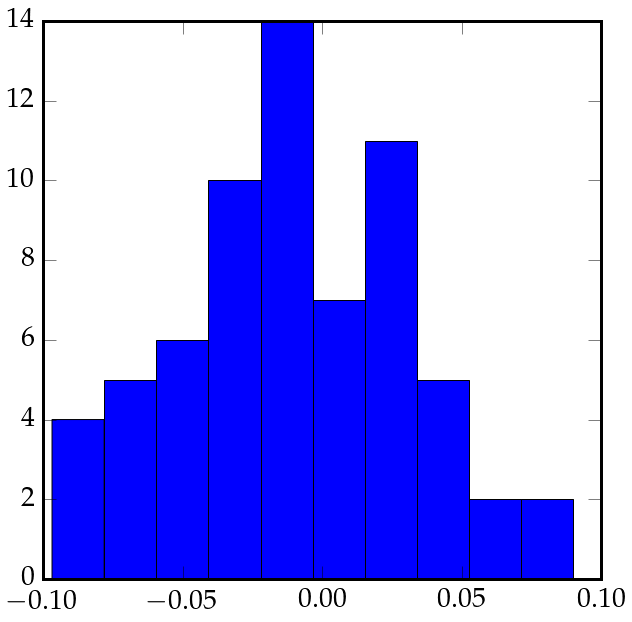

In [19]:
## plot parallaxes
fig = plt.figure(figsize=(10., 10.))
gs = gridspec.GridSpec(100,100) 
ax = plt.subplot(gs[:,:])
ax.hist(par_around)

In [20]:
# 3D relative velocity cf. surroundings
def get3Dv(vx,dvx,vy,dvy,vz,dvz):
    v = np.sqrt(vx**2+vy**2+vz**2)
    dv = (1/v)*np.sqrt((vx*dvx)**2+(vy*dvy)**2+(vz*dvz)**2)
    return v, dv


vra = prop_motion_to_km_s(mu_ra-avg_pmRA_around, D)
dvra = prop_motion_to_km_s(err_mu_ra+err_avg_pmRA_around, D)


vdec = prop_motion_to_km_s(mu_dec-avg_pmDE_around, D)
dvdec = prop_motion_to_km_s(err_mu_dec+err_avg_pmDE_around, D)

vr = drv
err = err_drv
v, dv = get3Dv(vra,dvra,vdec,dvdec,vr,err)
print v, "+/-", dv


46.033441932490454 +/- 18.59391292675925


In [21]:
def get_parametric_eq_line(X0,Y0,slope,x):
    x = np.array(x,dtype=float)
    y = Y0+slope*(x-X0)
    return y

def get_parametric_eq_line2points(X0,Y0, X1, Y1,x):
    x = np.array(x,dtype=float)
    y = Y0+(x-X0)*(X1-X0)/(Y1-Y0)
    return y
    
def plotVFTS682(ax):
    X0 = RAvfts682
    Y0 = DEvfts682

    # avg_pmRA_R136, err_avg_pmRA_R136, avg_pmDE_R136, err_avg_pmDE_R136

    
    ax.quiver(X0, Y0, mu_ra-avg_pmRA_R136, mu_dec-avg_pmDE_R136, color='r', label='VFTS682', scale=None, units='xy')
    # ax.annotate("shit", xy=(X0,Y0), xytext=(X0+mu_ra,Y0+mu_dec), arrowprops=dict(facecolor='black', shrink=0.05))
    ax.scatter(X0, Y0, color='r', marker='x',lw=3, s=100, zorder=10)
    
    # make error cone
    # ax.quiver(RAvfts682,DEvfts682,mu_ra-err_mu_ra,mu_dec+err_mu_dec, color="m", scale=1, units='xy')
    # ax.quiver(RAvfts682,DEvfts682,mu_ra+err_mu_ra,mu_dec-err_mu_dec, color="g", scale=1, units='xy')

    # xmin, xmax = ax.get_xlim()
    # x = np.linspace(xmin, xmax,20)

    # edge1 = ax.plot(x,get_parametric_eq_line2points(X0,Y0, X0+mu_ra-err_mu_ra, Y0+mu_dec+err_mu_dec, x), color='m')
    # edge2 = ax.plot(x,get_parametric_eq_line2points(X0,Y0, X0+mu_ra+err_mu_ra, Y0+mu_dec-err_mu_dec, x), color='g')
    # ax.fill_between(x,
    #                 get_parametric_eq_line2points(X0,Y0, X0+mu_ra-err_mu_ra, Y0+mu_dec+err_mu_dec, x),
    #                 get_parametric_eq_line2points(X0,Y0, X0+mu_ra+err_mu_ra, Y0+mu_dec-err_mu_dec, x),
    #                 lw=2, color='#808080', alpha=0.2)

    
    
def mkPlot(ax, pmDE, pmRA, DE, RA, color='b', plotpm=True, zorder=0):
    # notation
    x = pmRA
    y = pmDE
    xx = RA
    yy = DE
       
    #where the stars are
    ax.scatter(xx,yy,alpha=0.5, color=color, zorder=zorder)

    # # their proper motion
    if plotpm == True:
        ax.quiver(xx,yy,x,y, zorder=zorder+1, scale=None, units='inches')
    
    # beautification
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    # ax.yaxis.set_major_locator(MultipleLocator(0.1))
    # ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    # ax.xaxis.set_major_locator(MultipleLocator(0.2))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))


    ax.set_ylabel(r'$\mathrm{DEC}\ \mathrm{[degrees]}$ ',fontsize=30)
    ax.set_xlabel(r'$\mathrm{RA}\ \mathrm{[degrees]}$',fontsize=30)
    
    ax.tick_params(axis='both', which='major', width=2,
                   length=12, pad=10)
    ax.tick_params(axis='both', which='minor', width=2,
                   length=6, pad=10)
    


----------------
/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/data/Lennon_like_smaller.tsv
----------------
['DR2Name', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'epsi', 'Gmag', 'e_Gmag', 'RV', 'e_RV\n']
# stars surroundings: 71


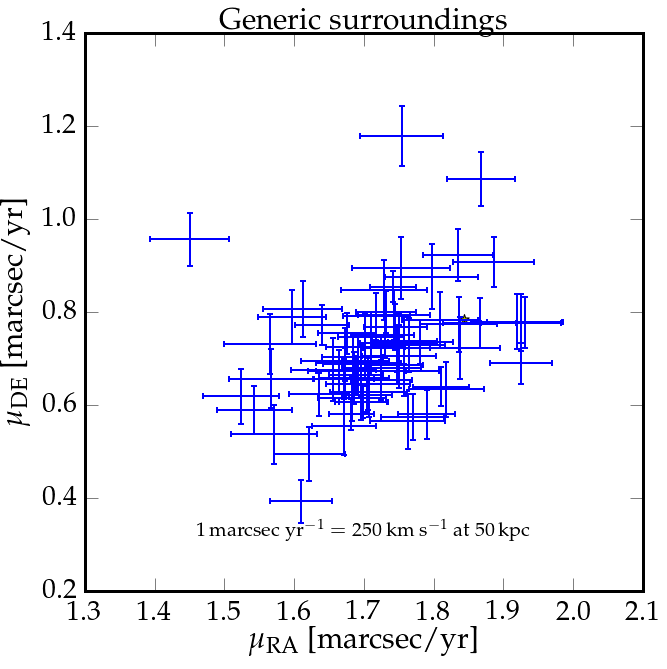

In [23]:
# plot the surrounding regions in proper motion space
fig = plt.figure(figsize=(10., 10.))
gs = gridspec.GridSpec(100,100) 
ax = plt.subplot(gs[:,:])
fname_around='/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/data/Lennon_like_smaller.tsv'
pmRA_around, e_pmRA_around, pmDE_around, e_pmDE_around, RA_around, e_RA_around, DE_around, e_DE_around, par_around, e_par_around = getData(fname_around) 
avg_pmRA_around, err_avg_pmRA_around, avg_pmDE_around, err_avg_pmDE_around= getAvg(pmRA_around,pmDE_around, e_pmRA_around, e_pmDE_around) # weighted with 1/error^2

print "# stars surroundings:", len(pmRA_around)

ax.errorbar(pmRA_around, pmDE_around, xerr=e_pmRA_around, yerr=e_pmDE_around, ms=10, lw=0, ecolor='b', elinewidth=2)
ax.errorbar(avg_pmRA_around, avg_pmDE_around, xerr=err_avg_pmRA_around, yerr=err_avg_pmDE_around, color='r', markersize=1000)
ax.set_xlabel("$\mu_\mathrm{RA}$ [marcsec/yr]", fontsize=30)
ax.set_ylabel("$\mu_\mathrm{DE}$ [marcsec/yr]", fontsize=30)
ax.set_title("Generic surroundings", fontsize=30)
ax.text(0.5,0.1,"$1\,\mathrm{marcsec\ yr^{-1}}=250\,\mathrm{km\ s^{-1}}$ at 50\,kpc", fontsize=20, transform=ax.transAxes, ha="center")

ax.scatter(mu_ra, mu_dec, marker='*', c='y', s=100)



the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Traceback (most recent call last):
  File "/scratch/mathieu/anaconda2/lib/python2.7/logging/__init__.py", line 874, in emit
    stream.write(fs % msg)
IOError: [Errno 32] Broken pipe
Logged from file logger.py, line 233


/scratch/mathieu/anaconda2/lib/python2.7/site-packages/aplpy/labels.py:432: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self.coord == x or self.axis.apl_tick_positions_world[ipos] > 0:
Traceback (most recent call last):
  File "/scratch/mathieu/anaconda2/lib/python2.7/logging/__init__.py", line 874, in emit
    stream.write(fs % msg)
IOError: [Errno 32] Broken pipe
Logged from file core.py, line 676
Traceback (most recent call last):
  File "/scratch/mathieu/anaconda2/lib/python2.7/logging/__init__.py", line 874, in emit
    stream.write(fs % msg)
IOError: [Errno 32] Broken pipe
Logged from file core.py, line 681


INFO: Auto-setting vmin to -2.286e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.479e+01 [aplpy.core]


DX 735.9750000000004
DY 735.375


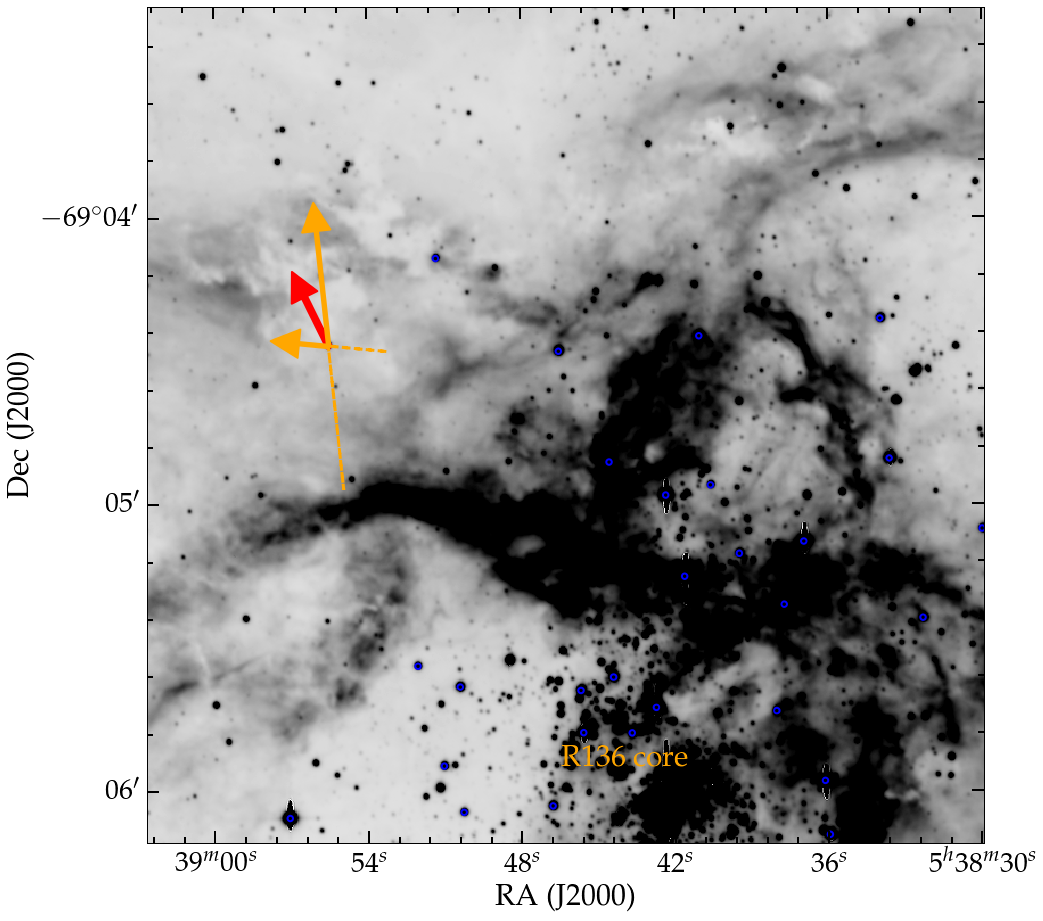

In [24]:
root = '/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/figures/ESO_field/'
fitsFileV  = root+'ADP_WFI_30DOR1_V89_V1.0.fits'

ffig = aplpy.FITSFigure(fitsFileV, figsize=(15,15))#, downsample=300) ###remove downsample=300 for final plot
ffig.show_grayscale(aspect='equal') #possible arg: aspect='auto'

ffig.set_theme('publication')
ffig.ticks.set_linewidth(2)
ffig.ticks.set_length(12)


#cut image on relevant part
# x axis
xmin, xmax = ffig._ax1.get_xlim()
ffig._ax1.set_xlim(3*xmax/4.0+237.2+50, xmax-1037.2-50)
xmin1, xmax1 = ffig._ax1.get_xlim()
print "DX", xmax1-xmin1

# y axis
ymin, ymax = ffig._ax1.get_ylim()
ffig._ax1.set_ylim(ymax/2.0+300+25, ymax/2+ymax/4-975-25-37)
ymin1, ymax1 = ffig._ax1.get_ylim()
print "DY", ymax1-ymin1

# ffig._ax1.set_xlim(4500.5, 7000.5) #cut image on y-direction
ffig.tick_labels.set_xformat('hh:mm:ss')
ffig.tick_labels.set_yformat('dd:mm')

#labels
ffig.add_label(0.57, 0.1, 'R136 core', relative=True, color="#FFA700", size=30)
ffig.show_markers(RA_around, DE_around, edgecolor='b', lw=2)
ffig.show_markers(RAvfts682, DEvfts682, edgecolor='r', layer='vfts682', lw=2)

# to scale arrows
len_factor = 0.05

# best value
ffig.show_arrows(RAvfts682, DEvfts682, len_factor*rel_pmRA, len_factor*rel_pmDEC, color='r', width=5, lw=2,head_length=25, head_width=25,)
# error-cone
ffig.show_arrows(RAvfts682, DEvfts682, len_factor*(rel_pmRA-err_rel_pmRA), len_factor*(rel_pmDEC+err_rel_pmDEC), color='#FFA700',head_length=25, head_width=25, width=3,  lw=2)
ffig.show_arrows(RAvfts682, DEvfts682, len_factor*(rel_pmRA+err_rel_pmRA), len_factor*(rel_pmDEC-err_rel_pmDEC), color='#FFA700',head_length=25, head_width=25, width=3,  lw=2)
# show prolungations in opposite direction
ffig.show_arrows(RAvfts682, DEvfts682, -len_factor*(rel_pmRA-err_rel_pmRA), -len_factor*(rel_pmDEC+err_rel_pmDEC), color='#FFA700', head_length=0, head_width=0, width=0,lw=3, linestyle='--')
ffig.show_arrows(RAvfts682, DEvfts682, -len_factor*(rel_pmRA+err_rel_pmRA), -len_factor*(rel_pmDEC-err_rel_pmDEC), color='#FFA700', head_length=0, head_width=0, width=0, lw=3, linestyle='--')

ffig.savefig(root+'/../main_plot_good.pdf', dpi=300)